# Práctica sobre algoritmos genéticos

<img src="imgs/tren.jpg">


Un área ferroviaria de carga/descarga con una única vía de entrada y otra salida se compone de tres muelles de carga/descarga: Op1, Op2 y Op3, correspondientes a contenedores, carbón y gas. Por tanto, cada tren que llega se dirige a un muelle en función de su carga. Un tren tarda en cargar o descargar un tiempo proporcional al número de vagones que arrastra. Cada día llegan secuencialmente n trenes. Si los trenes son de cargas distintas, pueden entrar en paralelo a los muelles. Cuando dos trenes con el mismo tipo de carga se encuentran seguidos, el segundo debe esperar por el primero, así como todos los demás que se encuentren por detrás.


Se nos plantea resolver, mediante un algoritmo genético, el problema de la ordenación en la entrada de los trenes para minimizar el tiempo de paso del conjunto de trenes.


<img src="imgs/docks.jpg" width="70%">

In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

## Trenes

En el siguiente código, <code>random_trains_generation</code> genera los trenes que llegarán en un día. Cada ordenación diferente de este conjunto corresponderá con un **individuo** en nuestro eaquema de algoritmo genético.

In [2]:
import random
from deap import base, creator, tools

class Train:
    def __init__(self, wagons, op, licence_plate):
        self.wagons = wagons
        self.op = op
        self.licence_plate = licence_plate

    def __str__(self):
        return "Número de vagones:" + str(self.wagons) 
        + "\n" + "Muelle de operaciones:" + str(self.op)
        + "\n" + "Matrícula:" + str(self.licence_plate)


def random_trains_generation(n):

    train_list = []
    
    for i in range(n):
        wagons = random.randint(10, 30)  # Cada tren puede arrastrar entre 10 y 30 vagones
        op = random.choice(["op1", "op2", "op3"])  # A cada tren se le asigna un tipo de carga
        train_list.append(Train(wagons, op, i))

    #print(len(train_list))
    return train_list
    


incoming_trains = random_trains_generation(100)  # supongamos que entran 7 trenes


# Crea una nueva reordenación de los trenes entrantes
def create_queue():
    aux = incoming_trains[:]
    random.shuffle(aux)
    return aux


class Trains(list):
    def __init__(self):
        list.extend(self, create_queue())


def evaluation(individual):
    dock_op_counters = {"op1" : 0, "op2" : 0, "op3" : 0}
    time = 0

    for train in individual:
        next_delay = train.wagons
        if dock_op_counters[train.op] == 0:
            dock_op_counters[train.op] = next_delay
        else:
            current_delay = dock_op_counters[train.op]
            for k, v in dock_op_counters.items():
                dock_op_counters[k] = max(0, v - current_delay)
            dock_op_counters[train.op] = next_delay
            time += current_delay

    time += max(dock_op_counters.values())
    return time,

In [3]:
def train_mate(ind1, ind2):
    cut_index = np.random.randint(len(ind1))
    ind1_left, ind1_right = ind1[:cut_index], ind1[cut_index:]
    ind2_left, ind2_right = ind2[:cut_index], ind2[cut_index:]
    
    pool1 = set(ind1) - (set(ind1_left) | set(ind2_right))
    pool2 = set(ind2) - (set(ind2_left) | set(ind1_right))
    
    ind1_right_new = []
    for t in ind2_right:
        if t not in ind1_left:
            ind1_right_new.append(t)
        else:
            ind1_right_new.append(pool1.pop())
    
    ind2_right_new = []
    for t in ind1_right:
        if t not in ind2_left:
            ind2_right_new.append(t)
        else:
            ind2_right_new.append(pool2.pop())
    
    ind1[:] = ind1_left + ind2_right_new
    ind2[:] = ind2_left + ind1_right_new
    
    return ind1, ind2

In [4]:
##################### DEAP #####################

creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", Trains, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("individual", creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluation)
toolbox.register("mate", train_mate)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=50)

In [5]:
hof = tools.HallOfFame(4)

stats = tools.Statistics(lambda indiv: indiv.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=300, stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg    	min	max 
0  	50    	1064.32	964	1223
1  	30    	1026.8 	953	1108
2  	31    	1006.68	953	1064
3  	31    	983.34 	953	1042
4  	26    	967.88 	953	1047
5  	25    	958.64 	922	1047
6  	36    	948.56 	922	979 
7  	33    	942.5  	916	990 
8  	27    	933.32 	910	1000
9  	34    	927.02 	910	997 
10 	25    	920.28 	884	981 
11 	28    	917.62 	854	964 
12 	34    	914.16 	854	979 
13 	24    	905.42 	854	972 
14 	27    	894.52 	854	962 
15 	31    	886.58 	854	938 
16 	31    	875.32 	852	944 
17 	27    	864.72 	852	906 
18 	34    	864.04 	847	924 
19 	31    	863    	847	934 
20 	36    	859.14 	839	976 
21 	20    	851.98 	839	912 
22 	37    	853.12 	839	934 
23 	30    	851.82 	833	944 
24 	30    	843.54 	802	900 
25 	34    	844.72 	802	953 
26 	34    	836.14 	802	895 
27 	31    	827.3  	786	921 
28 	35    	811.72 	786	900 
29 	38    	805.58 	782	889 
30 	37    	803.66 	782	870 
31 	23    	798.74 	782	891 
32 	28    	797.52 	782	911 
33 	25    	787.34 	782	853 
34 	22    	792.28 	7

293	39    	701.64 	691	814 
294	33    	702.46 	691	780 
295	37    	704.16 	691	823 
296	30    	698.46 	691	783 
297	28    	703.34 	691	795 
298	25    	700.36 	691	779 
299	31    	700.56 	691	775 
300	30    	701.62 	691	839 


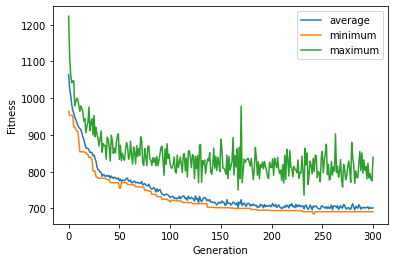

In [6]:
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

Para tener una idea de lo bueno que puede ser un resultado vamos a calcular cuál sería el tiempo mínimo en una supuesta configuración ideal de trenes. Para ello, asumimos que cada tipo de operación no bloquea a las otras. Por tanto, sumamos los tiempos para cada operación de forma independiente. Ahora, entre estos tres valores resultantes, escogemos el máximo. Ese será el tiempo que, como mínimo, tardarían todos los trenes en pasar.

In [7]:
counters = {"op1":0, "op2":0, "op3":0}

for t in incoming_trains:
    counters[t.op] += t.wagons
    
print("Tiempo op1:", counters["op1"], "\nTiempo op2:", counters["op2"], "\nTiempo op3:", counters["op3"])
             
print("Por tanto, el tiempo mínimo será:", max(counters["op1"], counters["op2"], counters["op3"]))
print("Y el tiempo calculado por el AG es de:", hof[0].fitness)

Tiempo op1: 664 
Tiempo op2: 615 
Tiempo op3: 644
Por tanto, el tiempo mínimo será: 664
Y el tiempo calculado por el AG es de: (685.0,)


## Sanity check

Para detectar fácilmente si tenemos algún error en nuestro código, vamos a realizar algunas pruebas. Puede ser que nuestro algoritmo de cruce repita trenes en un mismo individuo. Esto no nos daría ningún error sintáctico y podría pasar inadvertido. Por tanto, como cada tren tiene una matrícula, veremos si todas ellas son diferentes.

In [8]:
licence_plates = set()
for t in hof[0]:
    licence_plates.add(t.licence_plate)
    
print(len(licence_plates))
print(sorted(list(licence_plates)))

100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
